In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd

from features.build_features import SubtypeOneHotEncoder, OneHotEncodeColumns, CopyColumn
from features.transformers import PropertyTypeDropper, CrucialPropertiesMissingDropper, LandSurfaceFixer, \
    TerraceSurfaceFixer, MyMinMaxScaler, FacadeImputer, LongitudeLatitudeImputer, LandSurfaceImputer, \
    BathroomCountImputer, ColumnDropper, UnderpopulatedBinaryColumnDropper

from utils import ImmoFeature as IF

In [3]:
df = pd.read_csv('../data/raw/immo-data.csv', low_memory=False)
df.head()

,ID,Locality,Postal Code,Build Year,Facades,Habitable Surface,Land Surface,Type,Subtype,Price,...,Heating Type,Is Holiday Property,Gas Water Electricity,Sewer,Sea view,Parking count inside,Parking count outside,url,Latitude,Longitude
0,10593948,Knokke-Heist,8300,2023.0,NaN,258.0,NaN,APARTMENT,PENTHOUSE,5995000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.immoweb.be/en/classified/apartment...,NaN,NaN
1,11180831,Uccle,1180,2013.0,4.0,840.0,4425.0,HOUSE,EXCEPTIONAL_PROPERTY,4950000,...,GAS,NaN,True,NaN,NaN,2.0,4.0,https://www.immoweb.be/en/classified/house/for...,NaN,NaN
2,11188967,Uccle,1180,2013.0,4.0,840.0,4425.0,HOUSE,HOUSE,4950000,...,NaN,NaN,NaN,NaN,NaN,2.0,2.0,https://www.immoweb.be/en/classified/house/for...,NaN,NaN
3,11050739,Maaseik,3680,2012.0,4.0,330.0,4744.0,HOUSE,VILLA,1150000,...,GAS,NaN,NaN,NaN,NaN,1.0,20.0,https://www.immoweb.be/en/classified/house/for...,NaN,NaN
4,11201542,Lommel,3920,NaN,4.0,NaN,4000.0,HOUSE,HOUSE,1150000,...,NaN,NaN,True,CONNECTED,NaN,NaN,50.0,https://www.immoweb.be/en/classified/house/for...,51.208163,5.30915


# split trainind and test data

In [4]:
X = df.drop(columns=[IF.price.value])
y = df[IF.price.value]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41, test_size=0.2)

train_data = pd.concat([X_train, y_train], axis=1)

In [5]:
pipeline = Pipeline([
    ("Properties need to be of selected subtypes and of normal sale", PropertyTypeDropper()),
    ("CrucialPropertiesMissingDropper", CrucialPropertiesMissingDropper()),
    ("One Hot Encode Subtypes", SubtypeOneHotEncoder()),
    ("One hot encoder", OneHotEncodeColumns(
        columns=[IF.kitchen_type.value, IF.state_of_building.value, IF.heating_type.value, IF.epc.value]
    )),
    ("Set Land Surface to 0 for Apartments", LandSurfaceFixer()),
    ("Set Terrace to 0 for NaN", TerraceSurfaceFixer()),
    ("Drop Columns with alot of missing values", ColumnDropper()),
    ("copy the price column", CopyColumn(IF.price.value, f'{IF.price.value}_scaled')),
    ("min max scaler", MyMinMaxScaler(excluded=[IF.price.value])),
    ("Facade imputer", FacadeImputer()), # TODO complete this
    ("longitude, latitude, imputer", LongitudeLatitudeImputer()),
    ("land surface imputer", LandSurfaceImputer()),
    ("bathroom count imputer", BathroomCountImputer()),
    ("from the columns that haver a binary value drop the ones that do not have enough 1's", UnderpopulatedBinaryColumnDropper(threshold=0.05)),
    # ("Transform column to 1 or 0", BinaryToFloatTransformer()),
    # normalize all data with min max scaling except for the price
    # impute missing values for Facades, Latitude, Longitude, bathroomcount, land surface
])
train_data = pipeline.fit_transform(train_data)
# drop column Price_scaled
train_data = train_data.drop(columns=[f"{IF.price.value}_scaled"])
train_data

,Price,Postal Code,Facades,Habitable Surface,Land Surface,Bedroom Count,Bathroom Count,Terrace Surface,Latitude,Longitude,...,Heating Type_FUELOIL,Heating Type_GAS,Heating Type_nan,EPC_A,EPC_B,EPC_C,EPC_D,EPC_E,EPC_F,EPC_nan
0,520000,0.267015,4.0,0.002439,0.008349,0.042857,0.043478,0.000000,0.537990,0.672287,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,150000,0.670930,2.0,0.001123,0.001058,0.042857,0.000000,0.001527,0.459484,0.382924,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,249000,0.000000,2.0,0.000840,0.000000,0.028571,0.000000,0.000000,0.573576,0.488768,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,529000,0.978648,2.0,0.001906,0.004859,0.042857,0.000000,0.000000,0.603347,0.290307,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,258000,0.762900,2.0,0.003721,0.000000,0.071429,0.000000,0.000000,0.533188,0.364608,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58740,498000,0.137344,2.0,0.002122,0.006078,0.042857,0.000000,0.000000,0.627687,0.614743,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
58741,695000,0.113212,2.0,0.003914,0.001176,0.085714,0.043478,0.000000,0.668429,0.507219,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58742,381000,0.958630,2.0,0.001509,0.002215,0.042857,0.000000,0.000000,0.580928,0.366171,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58743,565000,0.834075,2.0,0.001362,0.000000,0.042857,0.043478,0.003511,0.562462,0.222620,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


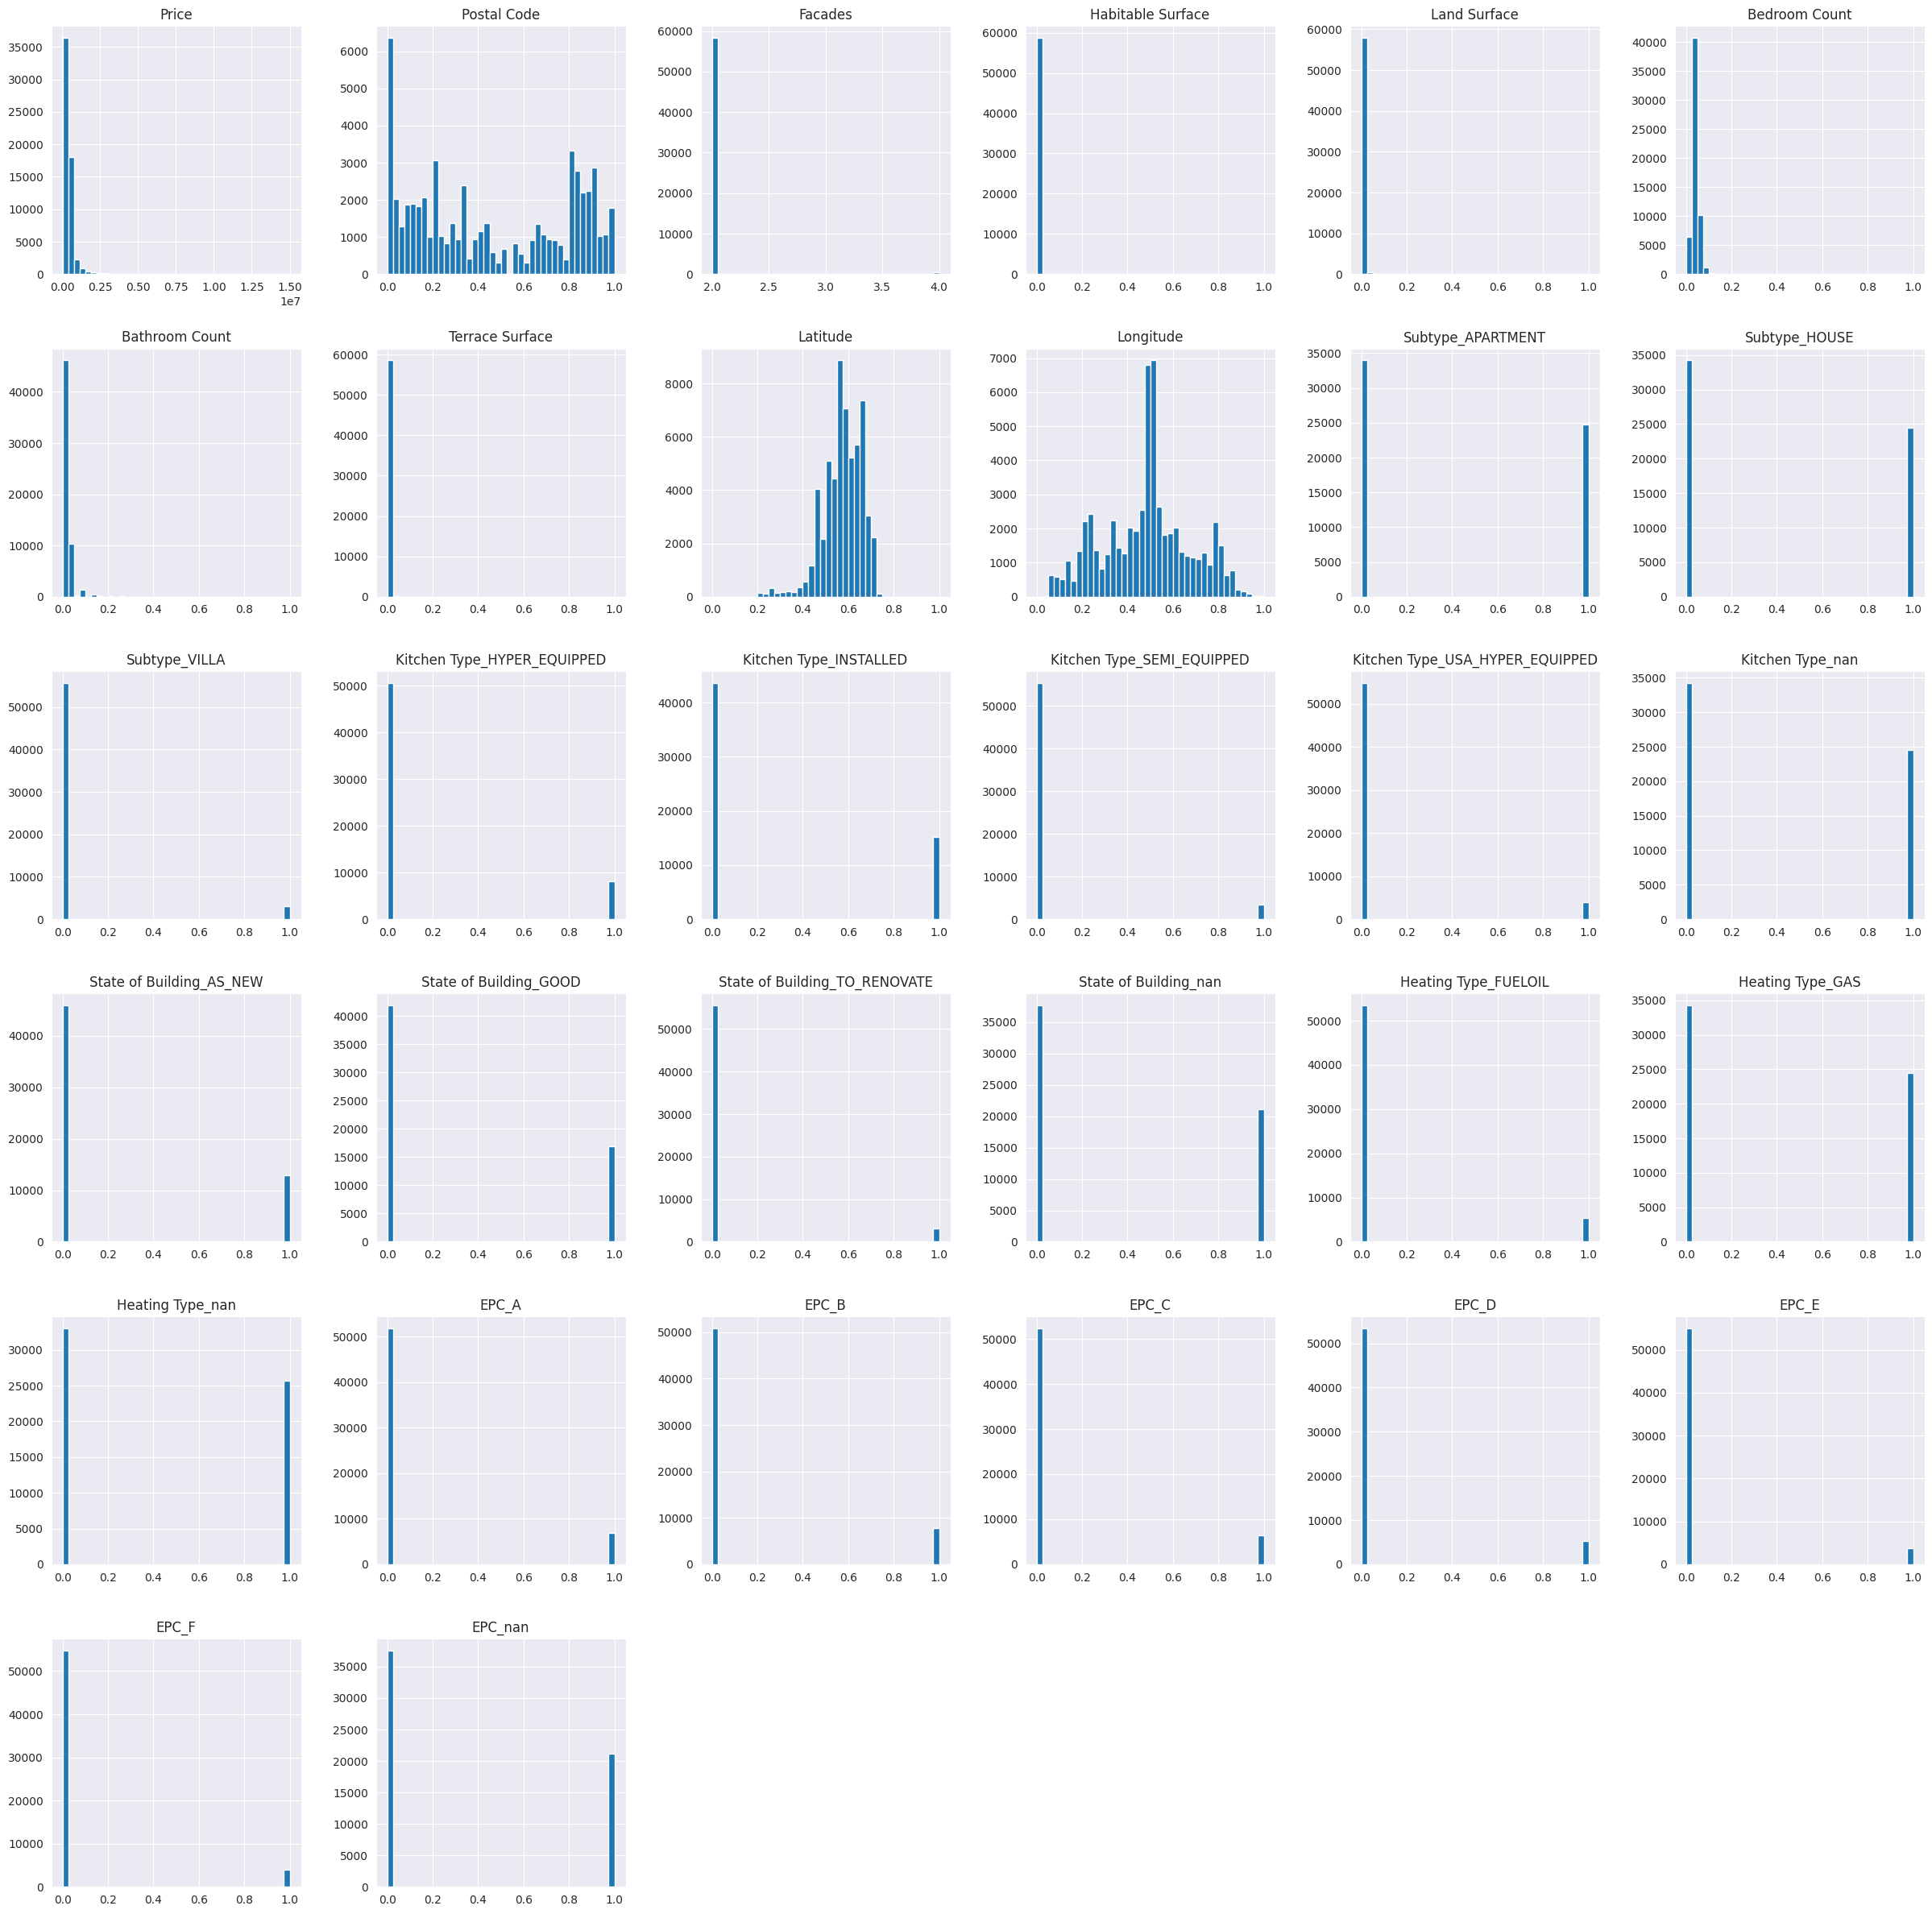

In [6]:
_ = train_data.hist(figsize=(30,30), bins=40)

<Axes: >

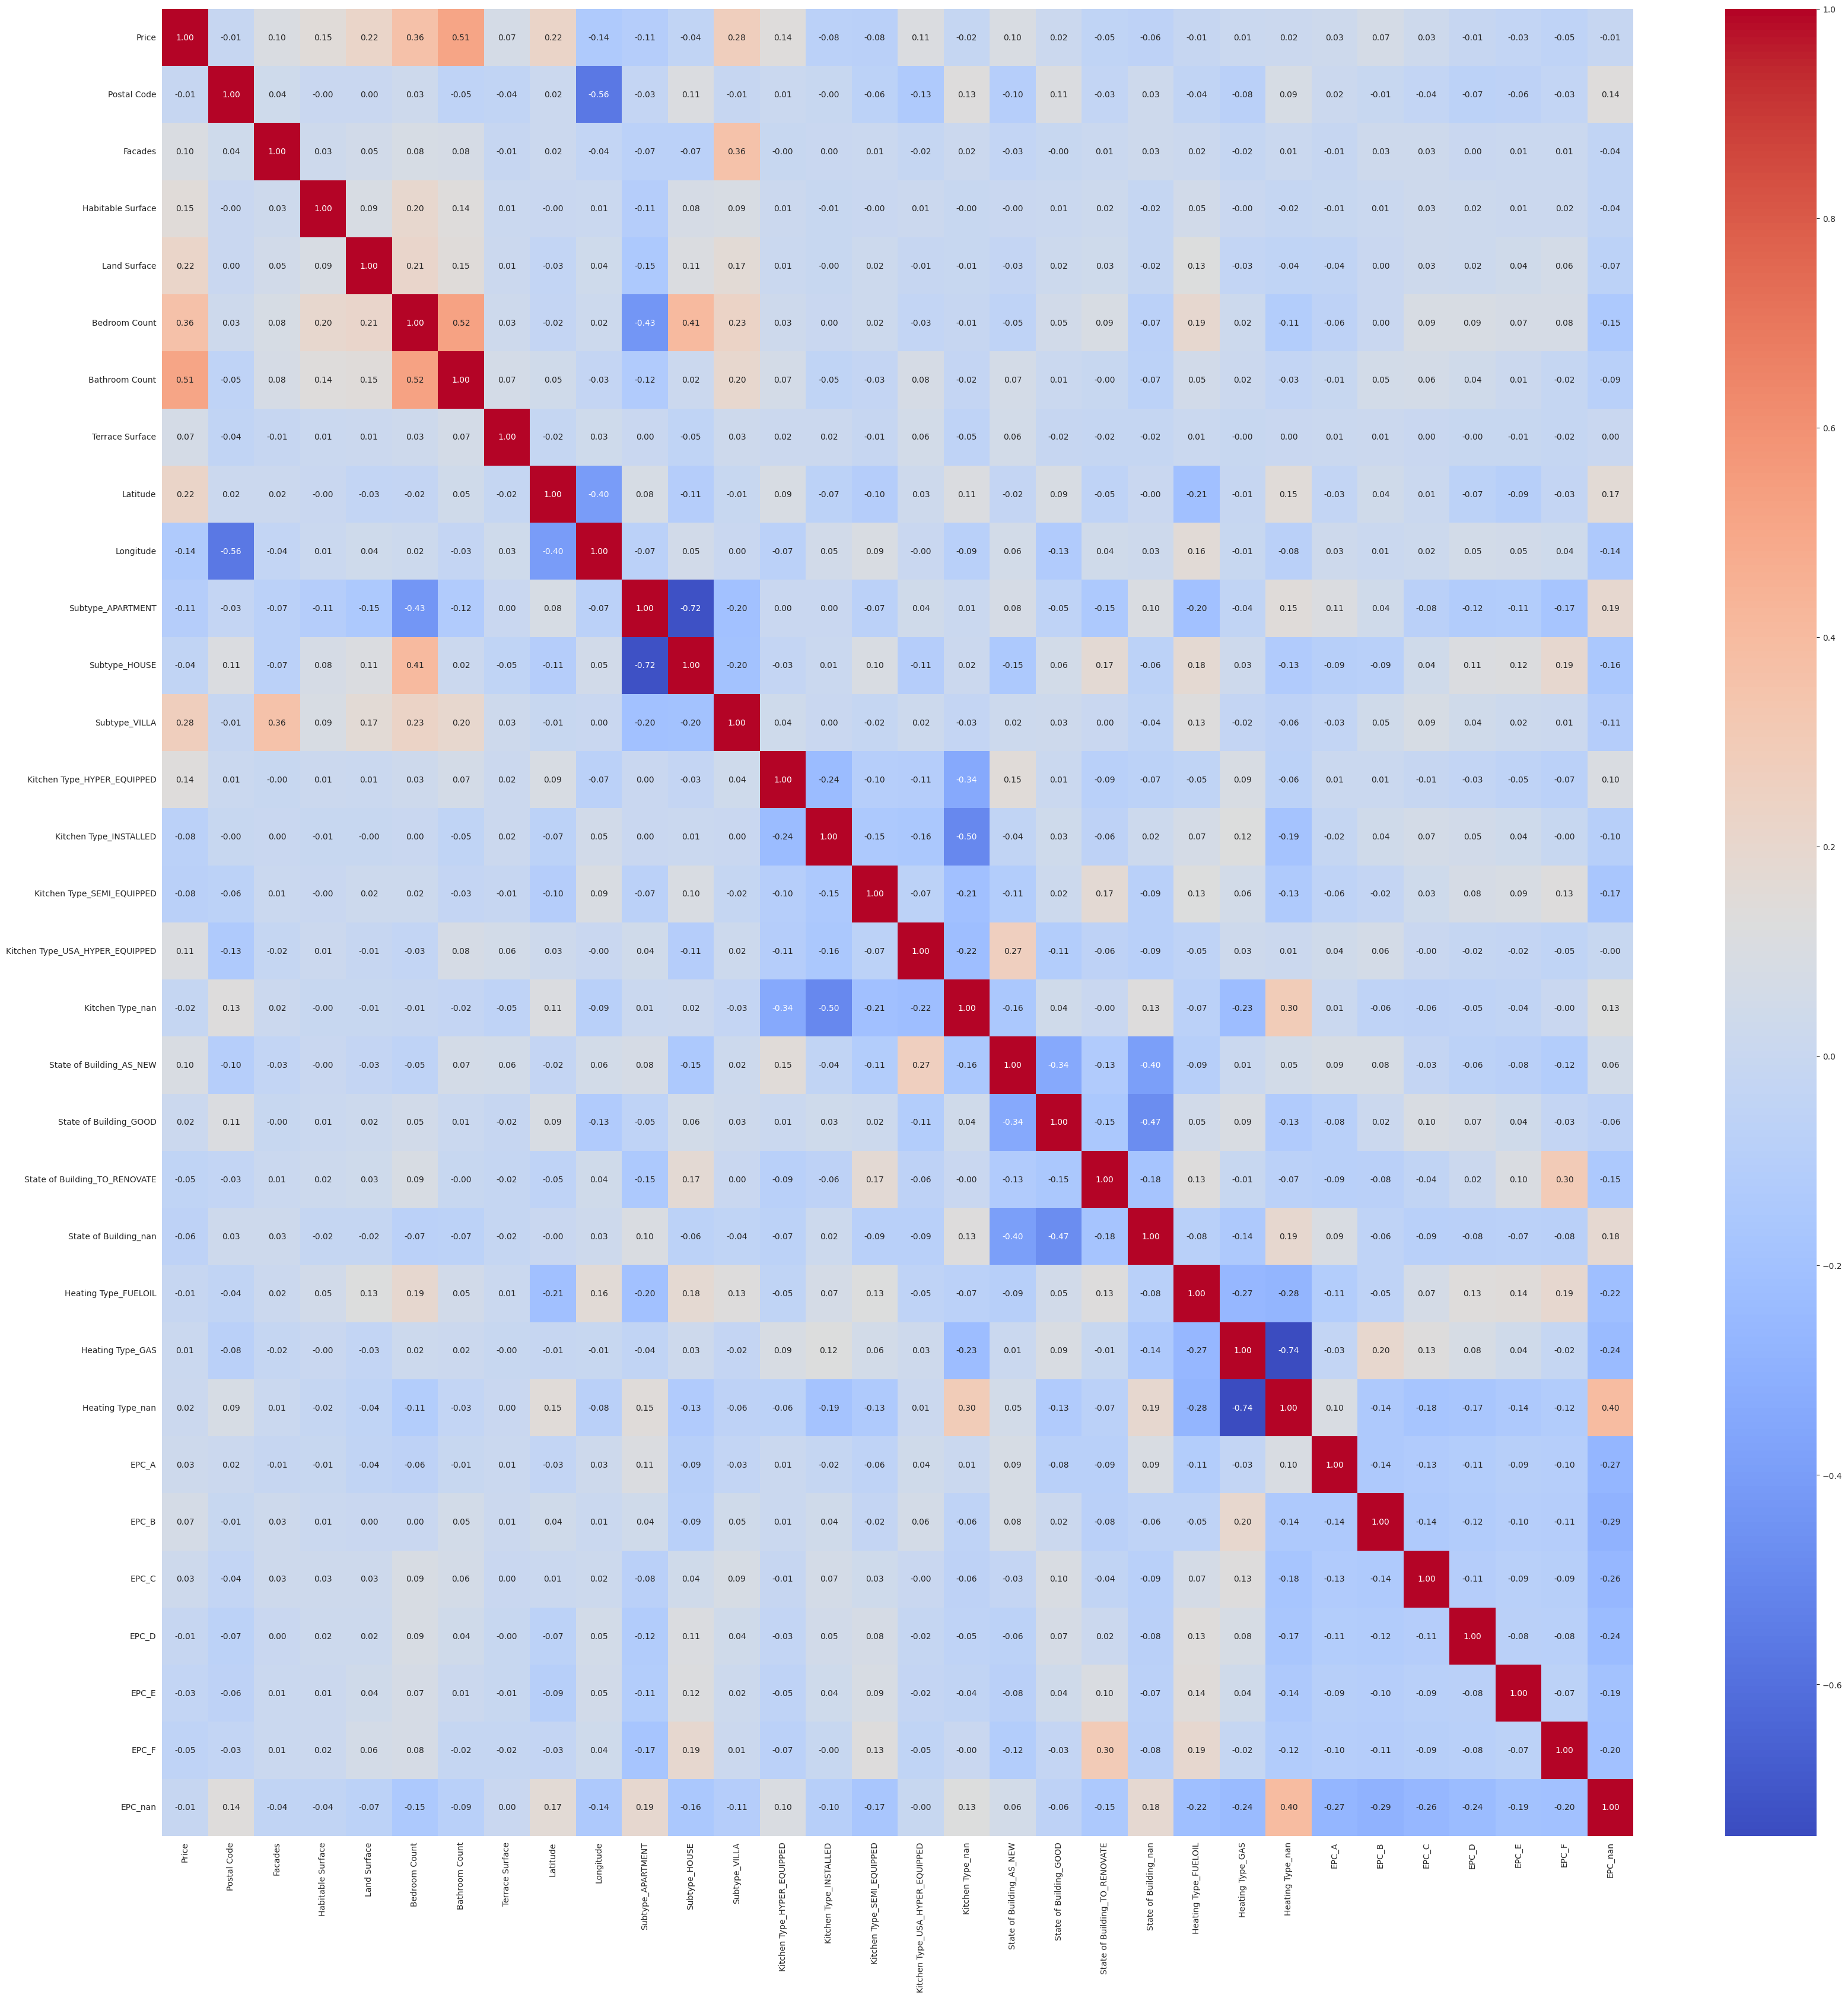

In [7]:
plt.figure(figsize=(40,40))
# plot the correlation matrix with 2 numbers after the comma
sns.heatmap(train_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')

In [8]:
X_train = train_data.drop(columns=[IF.price.value])
y_train = train_data[IF.price.value]

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [9]:
test_data = pd.concat([X_test, y_test], axis=1) # TODO join the dataframes
pipeline = Pipeline([
    ("Properties need to be of selected subtypes and of normal sale", PropertyTypeDropper()),
    ("CrucialPropertiesMissingDropper", CrucialPropertiesMissingDropper()),
    ("One Hot Encode Subtypes", SubtypeOneHotEncoder()),
    ("One hot encoder", OneHotEncodeColumns(
        columns=[IF.kitchen_type.value, IF.state_of_building.value, IF.heating_type.value, IF.epc.value]
    )),
    ("Set Land Surface to 0 for Apartments", LandSurfaceFixer()),
    ("Set Terrace to 0 for NaN", TerraceSurfaceFixer()),
    ("Drop Columns with alot of missing values", ColumnDropper()),
    ("copy the price column", CopyColumn(IF.price.value, f'{IF.price.value}_scaled')),
    ("min max scaler", MyMinMaxScaler(excluded=[IF.price.value])),
    ("Facade imputer", FacadeImputer()), # TODO complete this
    ("longitude, latitude, imputer", LongitudeLatitudeImputer()),
    ("land surface imputer", LandSurfaceImputer()),
    ("bathroom count imputer", BathroomCountImputer()),
    ("from the columns that haver a binary value drop the ones that do not have enough 1's", UnderpopulatedBinaryColumnDropper(threshold=0.05)),
    # ("Transform column to 1 or 0", BinaryToFloatTransformer()),
    # normalize all data with min max scaling except for the price
    # impute missing values for Facades, Latitude, Longitude, bathroomcount, land surface
])
test_data = pipeline.fit_transform(test_data)
# drop column Price_scaled
test_data = test_data.drop(columns=[f"{IF.price.value}_scaled"])
train_data.head()

,Price,Postal Code,Facades,Habitable Surface,Land Surface,Bedroom Count,Bathroom Count,Terrace Surface,Latitude,Longitude,...,Heating Type_FUELOIL,Heating Type_GAS,Heating Type_nan,EPC_A,EPC_B,EPC_C,EPC_D,EPC_E,EPC_F,EPC_nan
0,520000,0.267015,4.0,0.002439,0.008349,0.042857,0.043478,0.000000,0.537990,0.672287,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,150000,0.670930,2.0,0.001123,0.001058,0.042857,0.000000,0.001527,0.459484,0.382924,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,249000,0.000000,2.0,0.000840,0.000000,0.028571,0.000000,0.000000,0.573576,0.488768,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,529000,0.978648,2.0,0.001906,0.004859,0.042857,0.000000,0.000000,0.603347,0.290307,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,258000,0.762900,2.0,0.003721,0.000000,0.071429,0.000000,0.000000,0.533188,0.364608,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
X_test = test_data.drop(columns=[IF.price.value])
y_test = test_data[IF.price.value]

reg.score(X_test, y_test)

-0.3897121639862908